# 7. 成交量指标
*市场短期是投票机，长期是称重机*

## 目录
1. 什么是成交量？
2. 如何计算成交量指标？
3. 如何用图形展示成交量？
4. 如何用成交量指标来编写策略？

## 什么是成交量？

成交量有三种可能，分别是量增、量减、量平。 

价格也有三种可能，分别是上涨、下跌、横盘。

量价理论表明价涨量增是上涨趋势的确认，反之价跌量增是下跌趋势的确认。

## 如何计算成交量指标？
---
### 1. ADV-平均成交量
$MA(volume,20)$

---

### 2. OBV
OBV属于市场的领先指标，计算方法是如果当天价格高于前一天的价格，当天成交量就用加的，反之就用减的来计算出OBV指标，这样有助于分析成交量与价格的关系。

---

### 3. A/D
A/D 指标在OBV的基础上对价格的波幅进行了计算，真实波幅越大，指标中的成交量占比越大。

$\frac{A}{D}=\frac{Close-Open}{High-Low}*Volume$

---

### 4. WVAP
按成交量来衡量价格的权重，成交量越大价格权重越大。

$sum(close * volume, 20)/sum(volume, 20)$

## 如何用图形展示成交量？

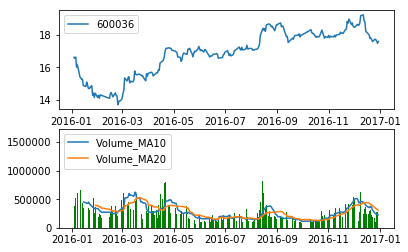

In [9]:
#ADV 平均成交量
import talib as ta
import tushare as ts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = ts.get_k_data('600036', start='2016-01-01', end='2016-12-31', ktype='D', autype='qfq')
data.index = pd.to_datetime(data['date'], format='%Y-%m-%d')

data['Volume_MA10'] = ta.abstract.MA(data, 10, price='volume')
data['Volume_MA20'] = ta.abstract.MA(data, 20, price='volume')

plt.subplot(2, 1, 1)
plt.plot(data.close, label='600036')
plt.legend(loc='upper left')
plt.subplot(2, 1, 2)
plt.bar(data.index, data.volume,color='g')
plt.subplot(2, 1, 2)
plt.plot(data['Volume_MA10'], label='Volume_MA10')
plt.plot(data['Volume_MA20'], label='Volume_MA20')
plt.legend(loc='upper left')
plt.show()

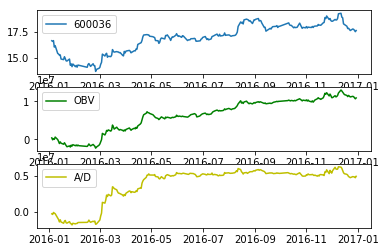

In [12]:
#OBV & A/D
data['OBV'] = ta.abstract.OBV(data)
data['AD'] = ta.abstract.AD(data)

plt.subplot(3, 1, 1)
plt.plot(data.close, label='600036')
plt.legend(loc='upper left')
plt.subplot(3, 1, 2)
plt.plot(data.OBV,'g', label='OBV')
plt.legend(loc='upper left')
plt.subplot(3, 1, 3)
plt.plot(data.AD, 'y', label='A/D')
plt.legend(loc='upper left')
plt.show()

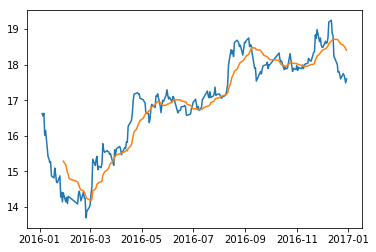

In [22]:
#VWAP
def ts_sum(ts, window=20):
    return ts.rolling(window).sum()

data['VWAP'] = ts_sum(data.volume*data.close)/ts_sum(data.volume)

plt.plot(data.close)
plt.plot(data.VWAP)
plt.show()

## 如何用成交量指标来编写策略？
### OBV突破策略
买入：
$OBV_t>High(OBV,20) \text{ and } Close_t>MA(Close,20)$

卖出：
$OBV_t<Low(OBV,20) \text{ or } Close_t< MA(Close,20)$

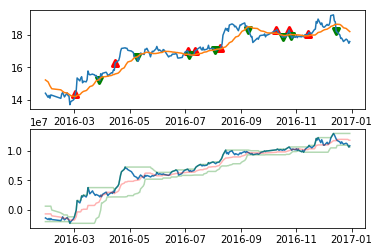

In [2]:
import talib as ta
import tushare as ts
import pandas as pd
import matplotlib.pyplot as plt

data = ts.get_k_data('600036', start='2016-01-01', end='2016-12-31', ktype='D', autype='qfq')
data.index = pd.to_datetime(data['date'], format='%Y-%m-%d')


data['OBV'] = ta.abstract.OBV(data)
data['OBV_MAX20'] = ta.abstract.MAX(data, 20, price='OBV')
data['OBV_MIN20'] = ta.abstract.MIN(data, 20, price='OBV')
data['OBV_MID20'] = (data['OBV_MAX20'] + data['OBV_MIN20'])/2
data['C_MA'] = ta.abstract.MA(data, 20, price='close')

buy_time = []
buy_price = []

sell_time = []
sell_price = []

data = data.dropna()
it = data.iterrows()
t0, d0 = next(it)
pos = 0

for t1, d1 in it:
    if pos==0 and d1.OBV >= d0.OBV_MAX20 and d1.close > d1.C_MA:
        buy_time.append(t1)
        buy_price.append(d1.close)
        pos=1
    elif pos==1 and (d1.OBV <= d0.OBV_MIN20 or d1.close < d1.C_MA):
        sell_time.append(t1)
        sell_price.append(d1.close)
        pos=0
    t0, d0 = t1, d1

plt.subplot(2,1,1)
plt.plot(data['close'])
plt.plot(data['C_MA'])
plt.scatter(buy_time, buy_price, c='r', marker='^', linewidths=3)
plt.scatter(sell_time, sell_price, c='g', marker='v', linewidths=3)
plt.subplot(2,1,2)
plt.plot(data.OBV)
plt.plot(data.OBV_MAX20, 'g', alpha=0.3)
plt.plot(data.OBV_MID20, 'r', alpha=0.3)
plt.plot(data.OBV_MIN20, 'g', alpha=0.3)
plt.show()

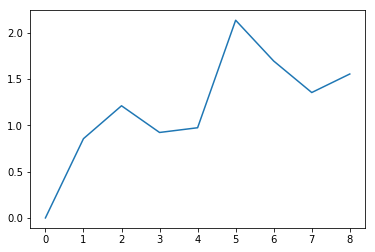

In [17]:
import numpy as np
money = np.array(sell_price) - np.array(buy_price)
money = list(money)
money.insert(0,0)
money = np.array(money)
capital = money.cumsum()
plt.plot(capital)
plt.show()

## 作业
参考以上代码用其他成交量指标做策略